Colab Link- https://colab.research.google.com/drive/1sr3V3Nrxz5bQGxbWV87NBbL8y0bulBfh?usp=sharing

In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
from fastbook import *

###CIFAR_10 Dataset

In [3]:
from fastai.vision.all import *
path = untar_data(URLs.CIFAR)

In [4]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(path, bs=64)

###Applying ResNet 50 model

In [5]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.430894,1.906714,0.401500,11:17
1,1.033549,1.046034,0.629833,11:16
2,0.793301,0.843580,0.711500,11:15
3,0.620378,0.583736,0.796417,11:15
4,0.527582,0.512798,0.824250,11:15


In [8]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])


(TensorImage([0.4760, 0.4685, 0.4240], device='cuda:0'),
 TensorImage([0.2202, 0.2185, 0.2427], device='cuda:0'))

In [9]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   get_items=get_image_files,
                   get_y=parent_label,
                   item_tfms=Resize(460),
                   batch_tfms=[*aug_transforms(size=size, min_scale=0.75),
                               Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

In [10]:
dls = get_dls(64, 224)


In [11]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([0.0110, 0.0774, 0.1368], device='cuda:0'),
 TensorImage([1.0113, 1.0691, 1.1253], device='cuda:0'))

In [12]:
model = xresnet50()
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.432934,1.313992,0.527583,11:20
1,1.001459,0.868518,0.691000,11:18
2,0.785417,0.691331,0.758167,11:18
3,0.575566,0.505399,0.823500,11:18
4,0.482419,0.444031,0.844750,11:18


In [13]:
dls = get_dls(128, 128)
learn = Learner(dls, xresnet50(), loss_func=CrossEntropyLossFlat(), 
                metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.316990,1.673635,0.483083,04:57
1,0.904789,0.945283,0.666000,04:58
2,0.641992,0.566225,0.808417,05:00
3,0.488755,0.465645,0.839000,04:59


In [14]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.652872,0.627547,0.786333,11:20


epoch,train_loss,valid_loss,accuracy,time
0,0.526220,0.512269,0.820833,11:19
1,0.497310,0.478509,0.832417,11:19
2,0.423831,0.425962,0.854917,11:18
3,0.342455,0.357712,0.876750,11:18
4,0.319672,0.336151,0.882750,11:18


In [15]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.890999972820282

In [21]:
#from fastai.vision.core import *
#path = untar_data(URLs.CIFAR)
#items = get_image_files(path)
#tds = Datasets(items, [PILImageBW.create, [parent_label, Categorize()]], splits=GrandparentSplitter()(items))
#dls = tds.dataloaders(after_item=[ToTensor(), IntToFloatTensor()])

###Mix-Up technique 

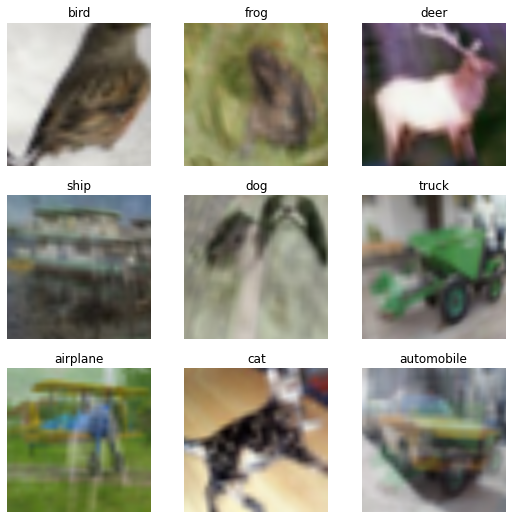

In [12]:
mixup = MixUp(0.5)
with Learner(dls, nn.Linear(3,4), loss_func=CrossEntropyLossFlat(), cbs=mixup) as learn:
    learn.epoch,learn.training = 0,True
    learn.dl = dls.train
    b = dls.one_batch()
    learn._split(b)
    learn('before_batch')

_,axs = plt.subplots(3,3, figsize=(9,9))
dls.show_batch(b=(mixup.x,mixup.y), ctxs=axs.flatten())


###Label Smoothing Technique  

In [5]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, ε:float=0.1, reduction='mean'):
        super().__init__()
        self.ε,self.reduction = ε,reduction
    
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = F.log_softmax(output, dim=-1)
        loss = reduce_loss(-log_preds.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_preds, target, reduction=self.reduction)
        return lin_comb(loss/c, nll, self.ε)

In [ ]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.652872,0.627547,0.786333,11:20


epoch,train_loss,valid_loss,accuracy,time
0,0.526220,0.512269,0.820833,11:19
1,0.497310,0.478509,0.832417,11:19
2,0.423831,0.425962,0.854917,11:18
3,0.342455,0.357712,0.876750,11:18
4,0.319672,0.336151,0.882750,11:18


###Prediction and Accuracy after Mix-up

In [ ]:
preds,targs = learn.tta()
accuracy(preds, targs).item()

0.890999972820282